In [55]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [56]:
def get_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)["Close"]
    return data

In [57]:
def calculate_returns(data):
    returns = np.log(data / data.shift(1))
    return returns[1:]

In [58]:
def objective_function(weights, mean_returns, covariance_matrix):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights))) * np.sqrt(252)
    return -portfolio_return / portfolio_volatility

In [59]:
def optimize_portfolio(returns):
    mean_returns = returns.mean()
    covariance_matrix = returns.cov()

    num_assets = len(mean_returns)
    initial_weights = np.ones(num_assets) / num_assets

    bounds = tuple((0, 1) for asset in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    result = minimize(objective_function, initial_weights, args=(mean_returns, covariance_matrix), method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x

In [60]:
def efficient_frontier(returns, num_portfolios=10000):
    mean_returns = returns.mean()
    covariance_matrix = returns.cov()

    portfolios = []
    for _ in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return = np.sum(mean_returns * weights) * 252
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights))) * np.sqrt(252)
        portfolios.append([portfolio_return, portfolio_volatility])

    return np.array(portfolios)

In [61]:
def plot_efficient_frontier(returns, tickers):
    efficient_frontier_data = efficient_frontier(returns)
    optimal_weights = optimize_portfolio(returns)
    optimal_return = np.sum(returns.mean() * optimal_weights) * 252
    optimal_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(returns.cov(), optimal_weights))) * np.sqrt(252)

    plt.figure(figsize=(10, 6))
    plt.scatter(efficient_frontier_data[:, 1], efficient_frontier_data[:, 0], c=efficient_frontier_data[:, 0] / efficient_frontier_data[:, 1], cmap='viridis', marker='o')
    plt.title('Frontière efficace')
    plt.xlabel('Risque (Volatilité annualisée)')
    plt.ylabel('Rendement annuel')
    plt.colorbar(label='Ratio de Sharpe')

    plt.scatter(optimal_volatility, optimal_return, color='red', marker='*', s=200, label='Portefeuille optimal')
    plt.legend(loc='upper left')
    plt.show()

    print("Poids du portefeuille optimal :")
    for i, ticker in enumerate(tickers):
        print(f"{ticker}: {optimal_weights[i]:.2f}")

[*********************100%***********************]  5 of 5 completed


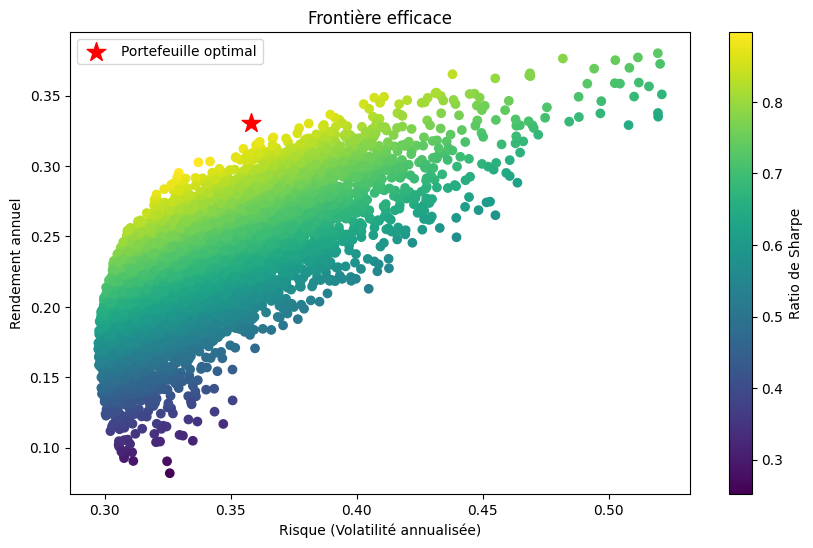

Poids du portefeuille optimal :
AAPL: 0.83
MSFT: 0.00
GOOGL: 0.00
AMZN: 0.00
TSLA: 0.17


In [62]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
start_date = '2019-01-01'
end_date = '2023-01-01'

data = get_data(tickers, start_date, end_date)

returns = calculate_returns(data)

plot_efficient_frontier(returns, tickers)